In [1]:
# %matplotlib qt5
# importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os, glob

In [3]:
data = pd.read_csv('july/first_week/feat_ext64_mpu1.csv')
data.dtypes.value_counts()
print(data.shape)
Class = pd.read_csv('july/first_week/Ymotion_resize64_fe_mpu1.csv')
print(Class.shape)
#data.dtypes.tail()

(202, 114)
(202, 1)


In [4]:
# to group the y "class"
Class.Class.value_counts()
tar = pd.DataFrame()
for col in Class.columns:
        if col in ['series', 'time']:
            continue
        tar['Class'] = Class.groupby(['series'])[col].mean()
tar.head()
tar.to_csv('Y_mpu1.csv', index=False)

In [4]:
# Calculate the correlation values
feature_cols = data.columns[:]
corr_values = data[feature_cols].corr()

In [5]:


# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

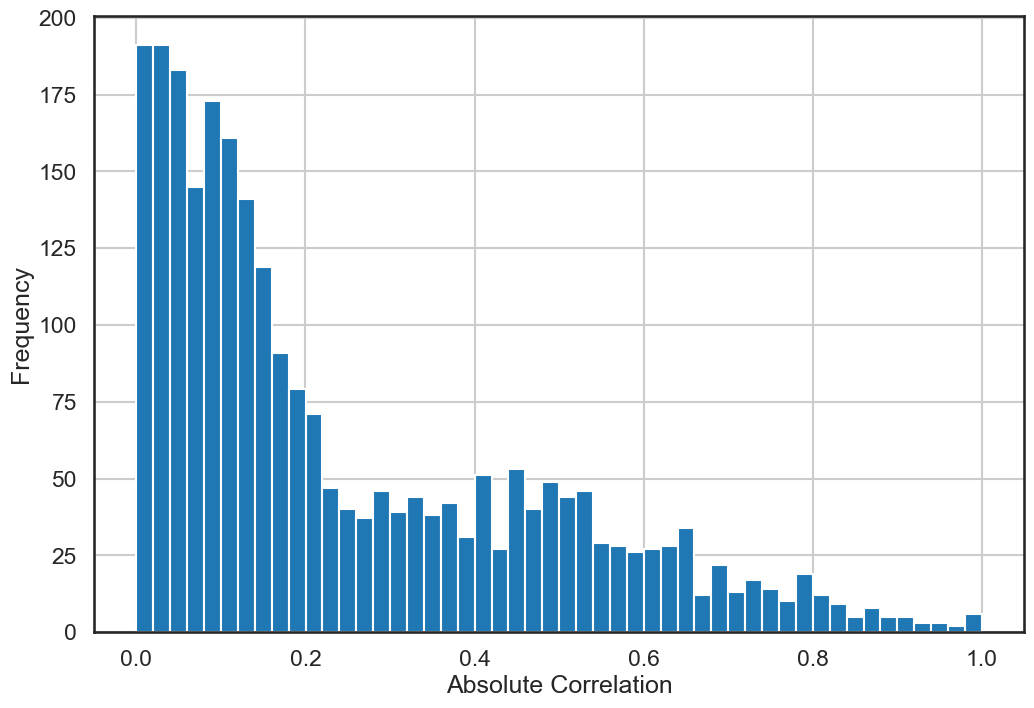

In [6]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [7]:
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
2440,total_angular_velocity_max,total_angular_velocity_abs_max,1.000000,1.000000
2426,total_angular_velocity_min,total_angular_velocity_abs_min,1.000000,1.000000
2534,total_linear_acceleration_min,total_linear_acceleration_abs_min,1.000000,1.000000
2539,total_linear_acceleration_max,total_linear_acceleration_abs_max,1.000000,1.000000
956,AccY_mean_abs_change,total_linear_acceleration_mean_abs_change,0.960068,0.960068
1013,AccY_mean_change_of_abs_change,total_linear_acceleration_mean_change_of_abs_c...,0.948247,0.948247
839,AccY_std,total_linear_acceleration_std,0.942139,0.942139
1117,AccY_abs_min,total_linear_acceleration_min,0.922900,0.922900
1124,AccY_abs_min,total_linear_acceleration_abs_min,0.922900,0.922900
848,AccY_max_to_min,AccY_abs_min,0.919657,0.919657


In [5]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.2, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], Class['Class']))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = Class.loc[train_idx, 'Class']

X_test  = data.loc[test_idx, feature_cols]
y_test  = Class.loc[test_idx, 'Class']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, Class, test_size=0.2, random_state=42)

In [5]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

Class
2.0      0.268293
5.0      0.243902
3.0      0.195122
4.0      0.170732
1.0      0.121951
Name: proportion, dtype: float64

In [ ]:
from scipy.stats import zscore

In [9]:
# Normalize using the norm = sqrt(sigma(x^2))

def normalize_columns(actual):
    # Normalize the set of columns
    actual = actual.apply(lambda column: column/np.linalg.norm(column), axis=0)
    
    # Calculate the norm for each column
    norms = np.linalg.norm(actual, axis=0)

    # Create a new DataFrame with column names and their corresponding norms
    #norm_df = pd.DataFrame({'Column': actual.columns, 'Norm': norms})
    
    return actual, norms

In [10]:
norm_Xtrain, norms = normalize_columns(X_train)
norm_Xtest =  X_test.div(norms)

In [19]:
norm_Xtest.head()

,AccX_mean,AccX_min,AccX_max,AccX_std,AccX_max_to_min,AccX_mean_abs_change,AccX_mean_change_of_abs_change,AccX_abs_max,AccX_abs_min,AccX_entropy,...,L1_norm_acceleration_max,L1_norm_acceleration_std,L1_norm_acceleration_max_to_min,L1_norm_acceleration_mean_abs_change,L1_norm_acceleration_mean_change_of_abs_change,L1_norm_acceleration_abs_max,L1_norm_acceleration_abs_min,L1_norm_acceleration_entropy,L1_norm_acceleration_skew,L1_norm_acceleration_kurtosis
95,0.074574,-0.356934,0.515869,0.264426,-1.445278,0.028944,0.000173,0.515869,0.000732,2.697143,...,2.326660,0.277656,2.164434,0.087131,0.000465,2.326660,1.074951,2.708419,1.641692,2.086480
15,0.144711,0.014893,0.306641,0.071540,20.589606,0.020675,-0.000122,0.306641,0.014893,2.619207,...,2.019287,0.252503,1.881911,0.052335,-0.000181,2.019287,1.072998,2.584185,0.582065,-0.582710
30,0.091457,-1.437744,0.729248,0.287129,-0.507217,0.127546,-0.000240,1.437744,0.011963,3.013662,...,3.949462,0.550801,4.777614,0.170309,-0.000095,3.949462,0.826660,2.872837,2.291302,6.433754
159,-0.069916,-0.361328,0.177734,0.158535,-0.491891,0.050653,0.000488,0.361328,0.001221,2.751280,...,2.391357,0.658673,8.487875,0.119788,0.001122,2.391357,0.281738,2.723332,0.192632,-1.295415
186,0.159927,-0.377441,0.955078,0.316361,-2.530403,0.150797,-0.000150,0.955078,0.001709,2.578911,...,3.647461,0.951887,21.970671,0.342150,-0.002493,3.647461,0.166015,2.718359,0.373785,-0.745594


In [12]:
mean_Xtrain = X_train.mean()
std_Xtrain = X_train.std()

zscores_Xtrain = (X_train - mean_Xtrain)/std_Xtrain
zscores_Xtest = (X_test - mean_Xtrain)/std_Xtrain

In [20]:
zscores_Xtest.head()
#print(std_Xtrain)
#print(mean_Xtrain)

,AccX_mean,AccX_min,AccX_max,AccX_std,AccX_max_to_min,AccX_mean_abs_change,AccX_mean_change_of_abs_change,AccX_abs_max,AccX_abs_min,AccX_entropy,...,L1_norm_acceleration_max,L1_norm_acceleration_std,L1_norm_acceleration_max_to_min,L1_norm_acceleration_mean_abs_change,L1_norm_acceleration_mean_change_of_abs_change,L1_norm_acceleration_abs_max,L1_norm_acceleration_abs_min,L1_norm_acceleration_entropy,L1_norm_acceleration_skew,L1_norm_acceleration_kurtosis
95,0.377756,0.370146,-0.134589,0.113612,-0.026135,-0.732736,-0.208883,-0.472069,-0.428604,0.077407,...,-0.405983,-0.637362,-0.304467,-0.316395,-0.038030,-0.405983,0.623839,0.731969,0.890099,0.210690
15,0.850390,1.204542,-0.567960,-1.080002,1.950386,-0.891064,-0.296323,-0.896723,0.269035,-0.366164,...,-0.717603,-0.731362,-0.316192,-0.705421,-0.150028,-0.717603,0.618654,0.101888,-0.234472,-0.411920
30,0.491531,-2.055238,0.307380,0.254106,0.058009,1.155039,-0.331297,1.398989,0.124689,1.878865,...,1.239240,0.383431,-0.196022,0.613562,-0.135009,1.239240,-0.035390,1.565860,1.579522,1.224724
159,-0.595919,0.360286,-0.834964,-0.541658,0.059383,-0.317106,-0.115618,-0.785729,-0.404513,0.385527,...,-0.340392,0.786568,-0.042049,0.048716,0.076025,-0.340392,-1.482195,0.807605,-0.647772,-0.578163
186,0.952932,0.324128,0.775139,0.434999,-0.123470,1.600199,-0.304489,0.419359,-0.380472,-0.595504,...,0.933067,1.882358,0.517477,2.534780,-0.550917,0.933067,-1.789448,0.782386,-0.455516,-0.449913


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [22]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(zscores_Xtrain, y_train)

In [23]:
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(zscores_Xtrain, y_train)

In [24]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(zscores_Xtrain, y_train)

In [25]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0], [0,1,2,3,4]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                l1             
           1         2         3         4         5         1         2   
15 -0.145500 -0.313759 -0.068620 -0.171140  0.645425  0.000000 -1.214953  \
18 -0.075721 -0.031737  0.133405  0.079409 -0.013735  0.000000  0.000000   
3  -0.140999 -0.332160  0.395357  0.214628 -0.170099  0.000000 -1.332164   
72  0.321717 -0.040682  0.118774 -0.216672 -0.197832  0.906186  0.000000   
17 -0.036958  0.098272 -0.103455 -0.105719  0.101207 -0.225950  0.000000   
33 -0.160179 -0.255285 -0.040820  0.400273 -0.010201  0.000000 -0.404458   
84 -0.147445 -0.203181 -0.090238 -0.123300  0.622299 -0.232102 -1.857989   
68 -0.362441  0.095997  0.046221  0.508799 -0.062194 -2.547584  0.000000   
0   0.342040 -0.187923  0.139137 -0.421294  0.198637  0.438718  0.000000   
46  0.298212 -0.228662 -0.002716  0.110649  0.066949  0.441672 -0.208357   

                                        l2                                 
           3         4         5         1         2         3         4   
15  0.000000 -0.860337  2.090150 -0.387127 -0.114007 -0.131155 -0.124661  \
18  0.000000  0.260273  0.000000 -0.074939  0.001636  0.202102  0.053753   
3   0.000000  1.389435  0.000000 -0.219701 -0.089659  0.634990  0.155301   
72  0.000000 -0.280770 -0.723662  0.781306 -0.024004  0.200409 -0.151693   
17 -0.157668  0.000000  0.000000 -0.041742 -0.003287 -0.223021 -0.072076   
33  0.000000  0.727531  0.000000 -0.331050 -0.091852 -0.125864  0.298238   
84  0.000000 -0.459892  2.495097 -0.339676 -0.077306 -0.148727 -0.082234   
68  0.000000  2.165468  0.000000 -0.966315 -0.006679  0.108879  0.381038   
0   0.000000 -0.868865  0.248133  0.859547 -0.047484  0.241886 -0.332184   
46  0.000000  0.000000  0.000000  0.778042 -0.091454  0.230940  0.122280   

              
           5  
15  1.759067  
18  0.012142  
3  -0.445468  
72 -0.637866  
17  0.125288  
33  0.113315  
84  1.696728  
68 -0.179179  
0   0.371624  
46  0.258593

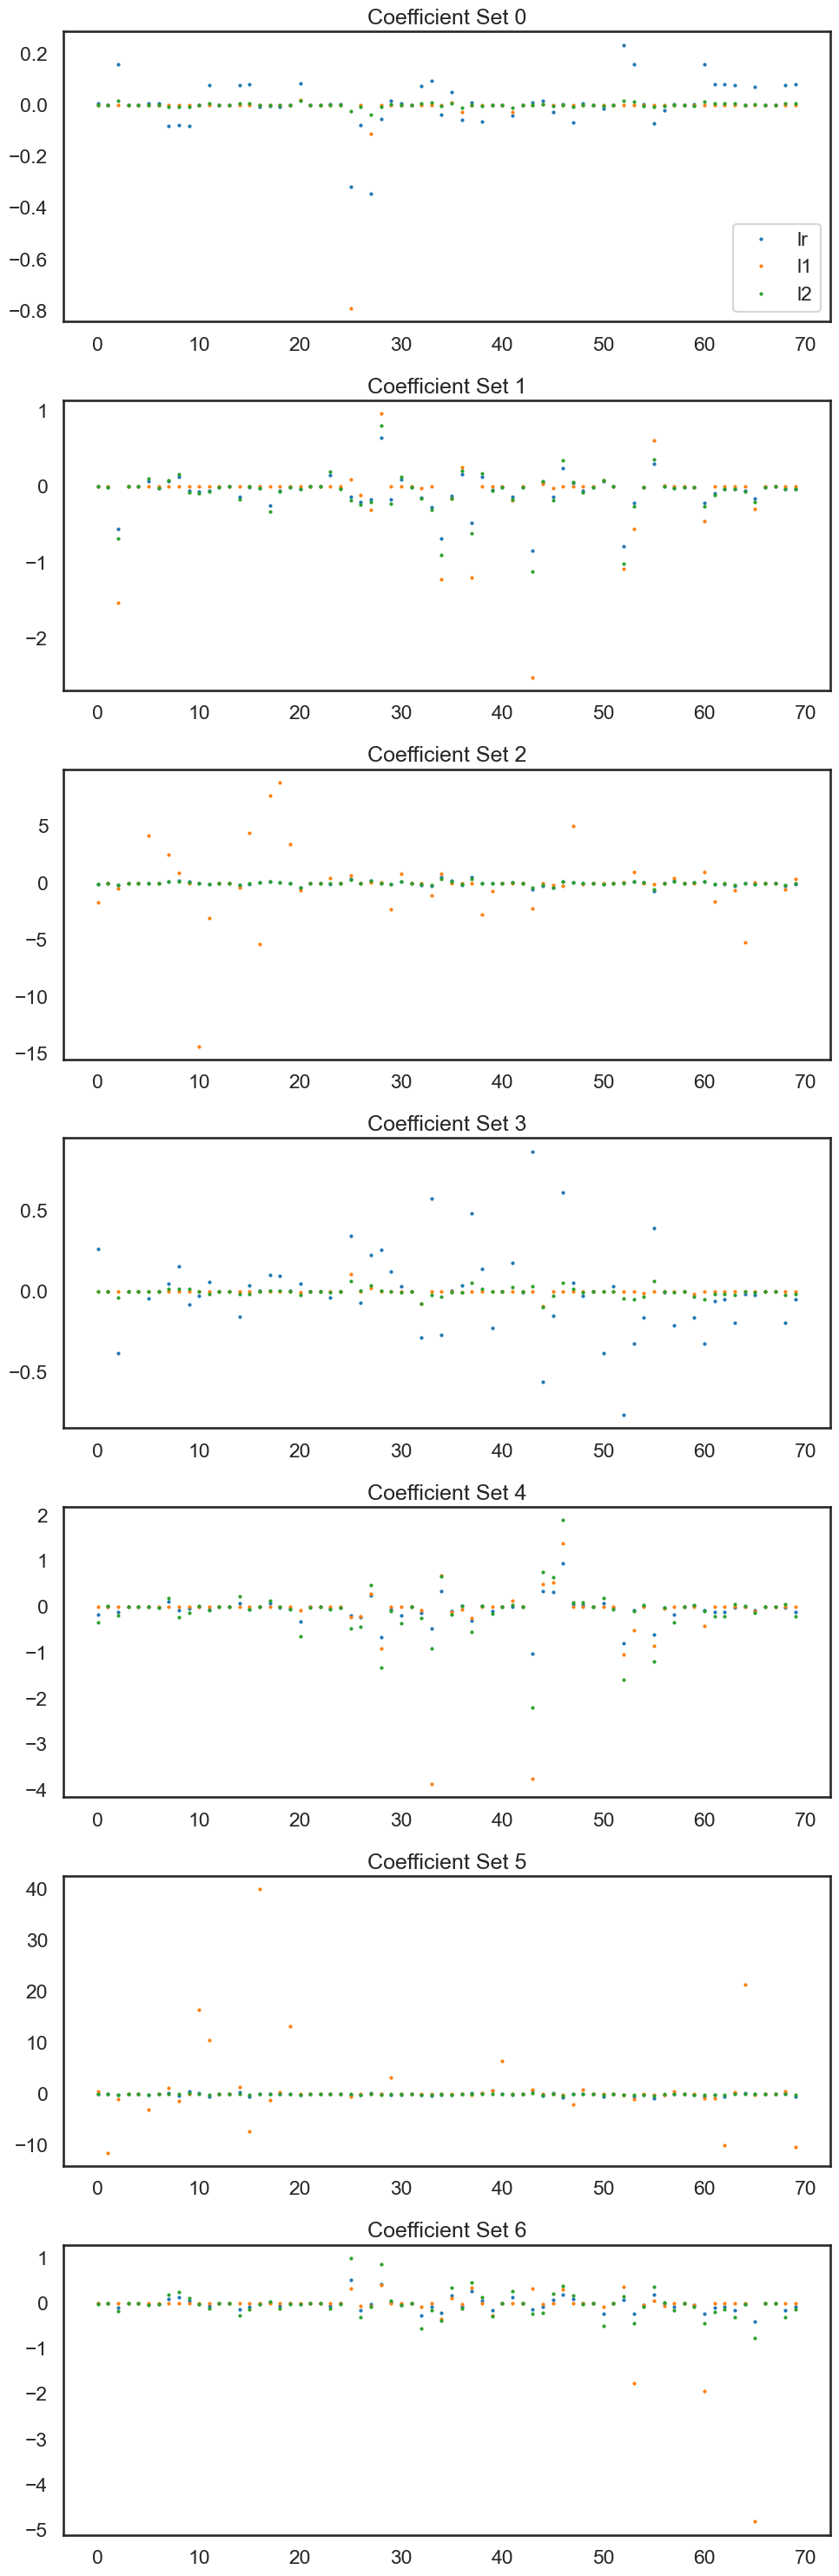

In [27]:
fig, axList = plt.subplots(nrows=7, ncols=1)
axList = axList.flatten()
fig.set_size_inches(10,30)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

In [26]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(zscores_Xtest), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(zscores_Xtest).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3.0,3.0,3.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,5.0,5.0,5.0
4,5.0,5.0,5.0


In [27]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,mean_squared_error, roc_auc_score
from sklearn.preprocessing import label_binarize

In [28]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [29]:
metrics

,lr,l1,l2
precision,0.979675,0.956486,0.935822
recall,0.975610,0.951220,0.926829
fscore,0.976138,0.950174,0.923459
accuracy,0.975610,0.951220,0.926829
auc,0.986111,0.969165,0.954831


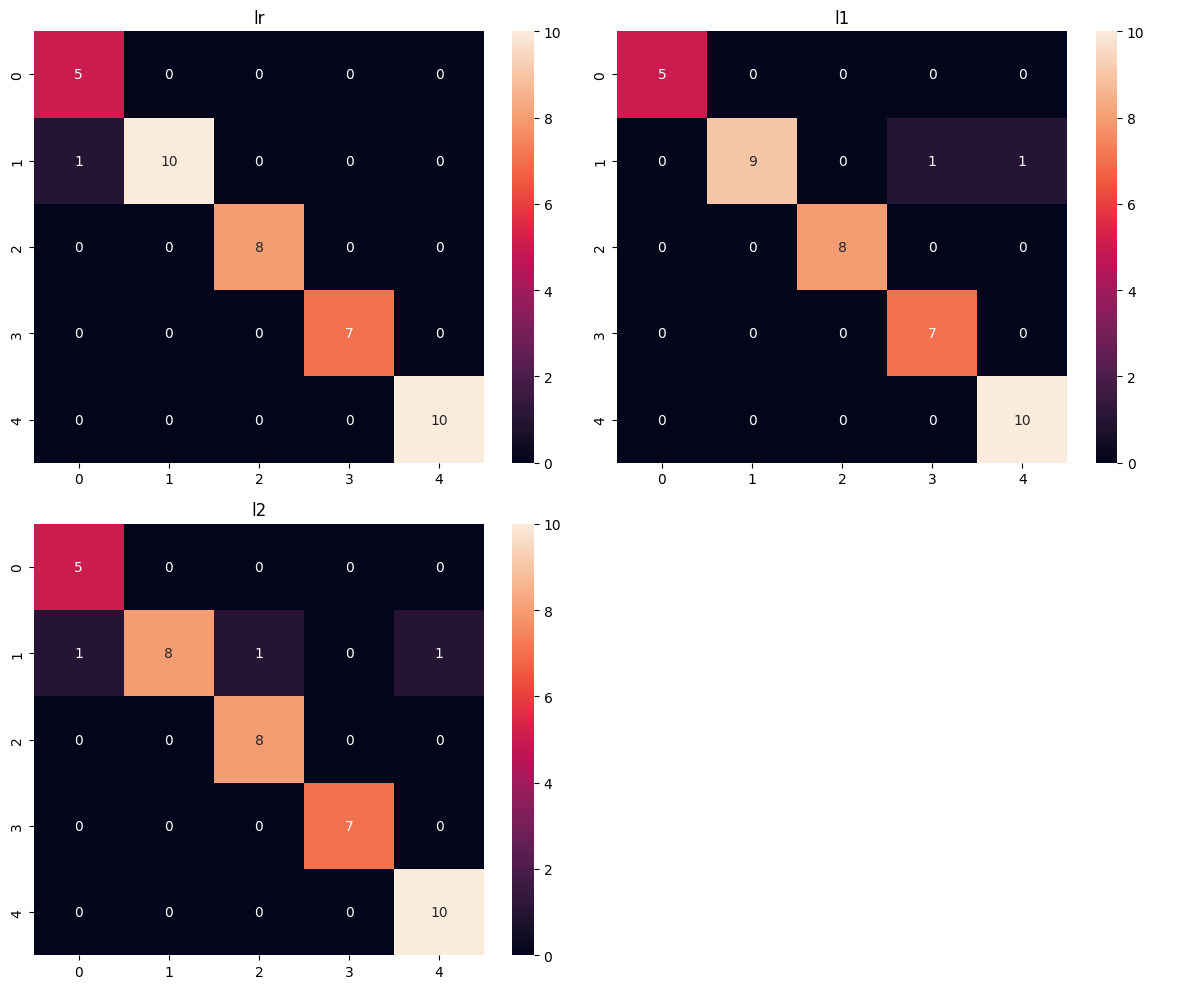

In [30]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [31]:
from sklearn.model_selection import KFold

# 10-fold Cross falidation
# Define the number of folds
n_splits = 10

X,y = data,Class

# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mse_list = []
accuracy_list = []
f1_list = []

# Loop over the folds
for train_index, test_index in kf.split(X):

    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize the data
    mean_Xtrain = X_train.mean()
    std_Xtrain = X_train.std()

    zscores_Xtrain = (X_train - mean_Xtrain)/std_Xtrain
    zscores_Xtest = (X_test - mean_Xtrain)/std_Xtrain
    
    # Train your models on the training set
    lr = LogisticRegression(solver='saga').fit(zscores_Xtrain, y_train)
    lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(zscores_Xtrain, y_train)
    lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga').fit(zscores_Xtrain, y_train)

    # Predict on the testing set
    y_pred_lr = lr.predict(zscores_Xtest)
    y_pred_lr_l1 = lr_l1.predict(zscores_Xtest)
    y_pred_lr_l2 = lr_l2.predict(zscores_Xtest)

    # Calculate the mean squared error and append it to the mse_list
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mse_lr_l1 = mean_squared_error(y_test, y_pred_lr_l1)
    mse_lr_l2 = mean_squared_error(y_test, y_pred_lr_l2)

    mse_list.append([mse_lr, mse_lr_l1, mse_lr_l2])

    # Calculate the accuracy and append it to the accuracy_list
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    accuracy_lr_l1 = accuracy_score(y_test, y_pred_lr_l1)
    accuracy_lr_l2 = accuracy_score(y_test, y_pred_lr_l2)

    accuracy_list.append([accuracy_lr, accuracy_lr_l1, accuracy_lr_l2])

    # Calculate the F1 score and append it to the f1_list
    f1_lr = f1_score(y_test, y_pred_lr, average='macro')
    f1_lr_l1 = f1_score(y_test, y_pred_lr_l1, average='macro')
    f1_lr_l2 = f1_score(y_test, y_pred_lr_l2, average='macro')

    f1_list.append([f1_lr, f1_lr_l1, f1_lr_l2])

# Calculate the mean and standard deviation of the mean squared error across all folds
mse_array = np.array(mse_list)
mean_mse = np.mean(mse_array, axis=0)
std_mse = np.std(mse_array, axis=0)

# Calculate the mean and standard deviation of the accuracy across all folds
accuracy_array = np.array(accuracy_list)
mean_accuracy = np.mean(accuracy_array, axis=0)
std_accuracy = np.std(accuracy_array, axis=0)

# Calculate the mean and standard deviation of the F1 score across all folds
f1_array = np.array(f1_list)
mean_f1 = np.mean(f1_array, axis=0)
std_f1 = np.std(f1_array, axis=0)

In [32]:
print("Mean Squared Error:")
print("LR:", mean_mse[0], "±", std_mse[0])
print("LR L1:", mean_mse[1], "±", std_mse[1])
print("LR L2:", mean_mse[2], "±", std_mse[2])

print("\nAccuracy:")
print("LR:", mean_accuracy[0], "±", std_accuracy[0])
print("LR L1:", mean_accuracy[1], "±", std_accuracy[1])
print("LR L2:", mean_accuracy[2], "±", std_accuracy[2])

print("\nF1 Score:")
print("LR:", mean_f1[0], "±", std_f1[0])
print("LR L1:", mean_f1[1], "±", std_f1[1])
print("LR L2:", mean_f1[2], "±", std_f1[2])

Mean Squared Error:
LR: 0.19976190476190475 ± 0.30260855700972866
LR L1: 0.15 ± 0.20976176963403032
LR L2: 0.15476190476190477 ± 0.2877073342896938

Accuracy:
LR: 0.9602380952380953 ± 0.043540191769441336
LR L1: 0.9700000000000001 ± 0.039999999999999994
LR L2: 0.9652380952380952 ± 0.03896623341995959

F1 Score:
LR: 0.965302086802087 ± 0.03673910646718901
LR L1: 0.9720255300255299 ± 0.04047925144854504
LR L2: 0.9696671661671662 ± 0.032547563602312
